In [24]:
from twitterscraper import query_tweets
import datetime as dt 
import pandas as pd 
import cld3
import re
from collections import Counter
from wordcloud import WordCloud

#Disable pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

from matplotlib import pyplot as plt
import seaborn as sns

In [26]:
def fetch_tweets(query, start_date, end_date, limit = 10000, language = "English"):
    """
    start_date: date in form year,month,day
    """

    tweets = query_tweets(query, begindate = start_date, enddate = end_date, limit = limit, lang = language)
    df = pd.DataFrame(t.__dict__ for t in tweets)
    return df

In [ ]:
start_date = dt.date(2019,10,1)
end_date = dt.date(2020,4,30)
query = "coronavirus OR covid OR covid19 OR covid-19 OR corona virus OR #COVID19, OR #CoronavirusOutbreak" 
tweets = fetch_tweets(query, start_date, end_date, language = 'english')

In [28]:
tweets.to_csv (r'./data/tweets.csv', index = False, header=True)


In [29]:
#Extract language of each tweet 
tweets['language'] = tweets['text'].apply(cld3.get_language).map(lambda x: x[0])

In [30]:
tweets[['text', 'language']]

,text,language
0,Resumiendo: que no tienes ni idea de lo que ha...,es
1,No hubo ningun genocidio.\n1º España no tenia ...,es
2,Las proteínas IFI44 e IFI44L favorecen las inf...,es
3,Middle East respiratory coronavirus (#MERS -Co...,en
4,ググった。これだ。JCI - IFN-I response timing relative ...,ja
...,...,...
5943,#CoronavirusArgentina\n-Hoy fueron confirmados...,es
5944,Cumpliendo con nuestro compromiso de apoyo dur...,es
5945,Are you a hospitality worker? Eater is survey...,en
5946,porque no creearan igual que han creado al cor...,es


In [31]:
english_tweets = tweets[tweets['language']=='en']
english_tweets[['text', 'language']]

,text,language
3,Middle East respiratory coronavirus (#MERS -Co...,en
11,Middle East respiratory coronavirus (#MERS -Co...,en
19,"Hi. Blondie, my sister Molly, and many others ...",en
20,How cats become infected with feline coronavir...,en
21,Researchers are hopeful they may have found a ...,en
...,...,...
5940,Yah that’s me right now eating my cheese burge...,en
5941,If anyone wants pizza tonight #COVID19 https:/...,en
5942,A favourite video with new lessons for #covid1...,en
5945,Are you a hospitality worker? Eater is survey...,en


In [52]:
english_tweets.shape

(2776, 23)

In [32]:
stemmer=PorterStemmer()

stop = stopwords.words('english')

In [33]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'https\S+', '', text)
    text = re.sub(r'pic\S*\s?', '', text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    text = ' '.join([word for word in text.split() if word not in (stop)])
    words=re.split("\\s+",text)
    stemmed_words=[stemmer.stem(word=word) for word in words]
    
    return ' '.join(stemmed_words)

In [34]:
re.sub(r'https\S+', '', tweets['text'].iloc[3])

'Middle East respiratory coronavirus (#MERS -CoV) spike (S) protein vesicular stomatitis virus pseudoparticle neutralization assays offer a reliable alternative to the conventional neutralization assay in human seroepidemiological studies\n\xa0…'

In [35]:
tweets['text'].iloc[3]

'Middle East respiratory coronavirus (#MERS -CoV) spike (S) protein vesicular stomatitis virus pseudoparticle neutralization assays offer a reliable alternative to the conventional neutralization assay in human seroepidemiological studies\nhttps://www.microbiologyresearch.org/content/journal/acmi/10.1099/acmi.0.000057#.XZvBEotTpvg.twitter\xa0…'

In [36]:
english_tweets['prep_text'] = english_tweets['text'].apply(preprocess)

In [37]:
english_tweets['prep_text']

3       middl east respiratori coronaviru mer cov spik...
11      middl east respiratori coronaviru mer cov spik...
19      hi blondi sister molli mani other share hous y...
20      cat becom infect felin coronaviru viru caus vi...
21      research hope may found clue fight fip deadli ...
                              ...                        
5940    yah right eat chees burger order mcd know slig...
5941                     anyon want pizza tonight covid19
5942              favourit video new lesson covid19 enjoy
5945    hospit worker eater survey impact covid19 save...
5947    love wisconsin hope wisconsin show republican ...
Name: prep_text, Length: 2776, dtype: object

In [46]:
word_to_list = [word for line in english_tweets['prep_text'] for word in line.split()]
word_to_list[:20]

['middl', 'east', 'respiratori', 'coronaviru', 'mer', 'cov', 'spike', 'protein', 'vesicular', 'stomat', 'viru', 'pseudoparticl', 'neutral', 'assay', 'offer', 'reliabl', 'altern', 'convent', 'neutral', 'assay']

## Plotting Word Occurrence

In [39]:
occurence = Counter(word_to_list).most_common(50)
occurence_df = pd.DataFrame(occurence, columns=['stemmed_word', 'frequency'])

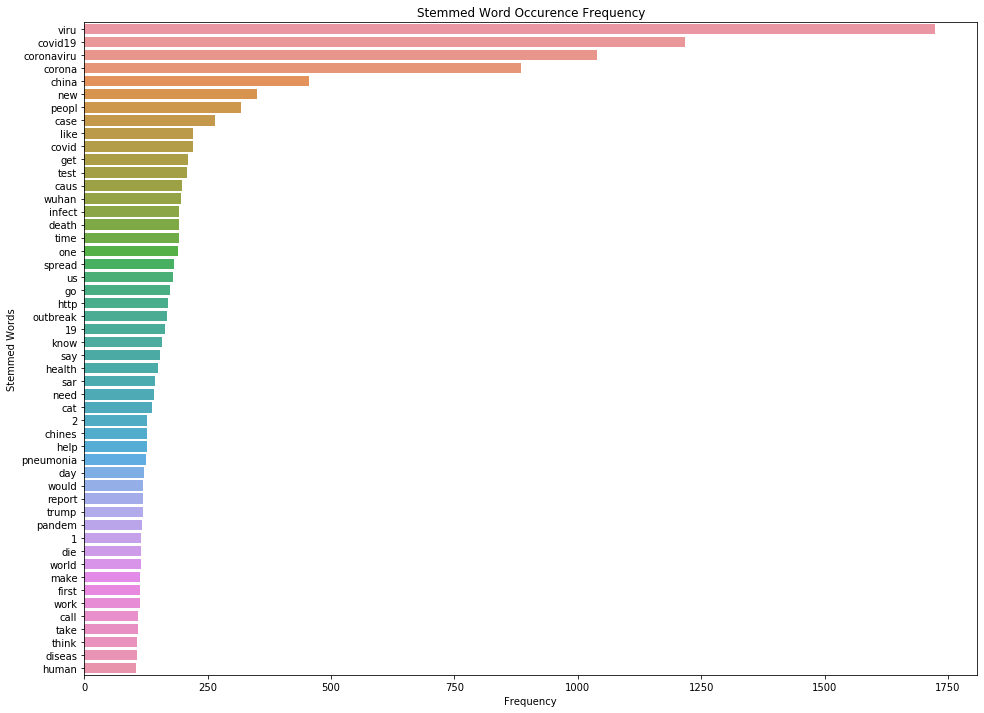

In [40]:
fig, ax = plt.subplots(figsize = (16, 12))
ax = sns.barplot(y="stemmed_word", x='frequency', 
                 ax = ax, data=occurence_df
                    ).set(title = "Stemmed Word Occurence Frequency", xlabel = 'Frequency', ylabel = 'Stemmed Words' )

## Plotting the Word Cloud

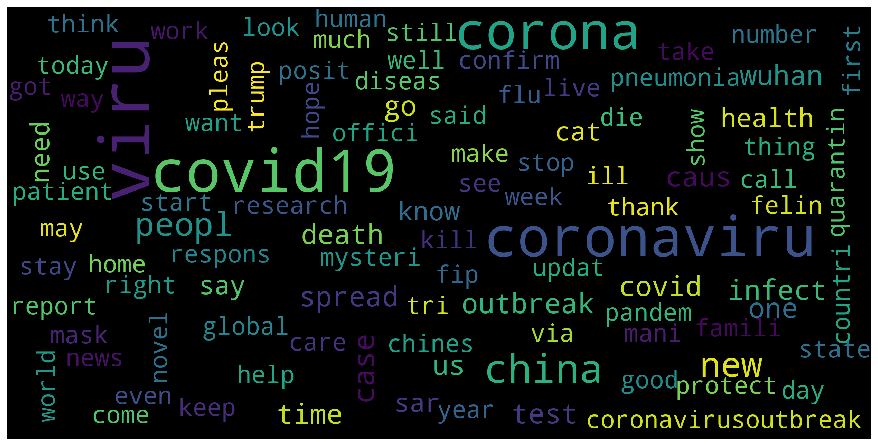

In [47]:
wordcloud = WordCloud(
    max_words=100,
    width=500,
    height=250,
    max_font_size=40, 
    scale=5,
    random_state=2,
    collocations=False,
    normalize_plurals=False
)

wordcloud.generate(' '.join(word_to_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Running Sentiment Analysis

In [48]:
#polarity score for each tweet
sia_object = SentimentIntensityAnalyzer()
polarity_scores = english_tweets['prep_text'].apply(lambda x: sia_object.polarity_scores(x))

polarity_scores_df = pd.DataFrame(list(polarity_scores))
polarity_scores_df.head()

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,1.000,0.000,0.0000
2,0.000,0.782,0.218,0.4404
3,0.000,1.000,0.000,0.0000
4,0.095,0.800,0.105,0.0772


## Categorizing sentiments as positive, negative or neutral

In [49]:
polarity_scores_df['sentiment'] = polarity_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
polarity_scores_df.head()


,neg,neu,pos,compound,sentiment
0,0.000,1.000,0.000,0.0000,neutral
1,0.000,1.000,0.000,0.0000,neutral
2,0.000,0.782,0.218,0.4404,positive
3,0.000,1.000,0.000,0.0000,neutral
4,0.095,0.800,0.105,0.0772,positive


In [50]:
sentiment_counts = pd.DataFrame.from_dict(Counter(polarity_scores_df['sentiment']), orient = 'index').reset_index()
sentiment_counts.columns = ['sentiment', 'frequency']
sentiment_counts

,sentiment,frequency
0,neutral,715
1,positive,1011
2,negative,1050


## Plotting sentiment frequency

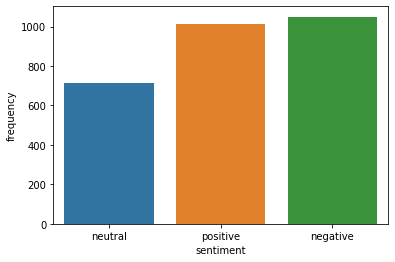

In [51]:
sns.barplot(y="frequency", x='sentiment', data=sentiment_counts).set
plt.show()